# 1. Import Libraries

### Utility

In [1]:
from scripts.health_check import HealthCheck
%load_ext autoreload
%autoreload 2

### Progress bar

In [2]:
# For display Progress bar
from tqdm import tqdm

### Data Manipulation

In [3]:
import numpy as np
import re
import pandas as pd
import time
from datetime import datetime, timedelta

import json

### HTML content

In [4]:
from bs4 import BeautifulSoup
import requests
# Selenium
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

# 2. Facilitating functions

In [5]:
def handle_job_function(string):
    if string:
        return string.replace(' ','-')
    else:
        return None
    
def handle_keyword(string):
    if string:
        return string.replace(' ','%20')
    else:
        return None
def handle_none_text(soup_obj):
    if soup_obj:
        return soup_obj.text
    else:
        return None
      
def load_soup(driver, url):
    get_url = driver.current_url
    print(f'Loading content... {get_url}')
    start_loading_time = time.time()
    driver.get(f'{url}')
    innerHTML = driver.execute_script('return document.body.innerHTML')
    time.sleep(1)
    loading_time = time.time() - start_loading_time
    print(f'Loaded! Time taken: {loading_time:.2f} seconds')
    soup = BeautifulSoup(innerHTML, "html.parser")
    return soup, driver

def clean_prefix_string(input_string, pattern):
    if not isinstance(input_string, str):
        raise ValueError("Input should be a string.")
    cleaned_string = re.sub(pattern, '', input_string)
    return cleaned_string

def extract_numerical(input_string):
    if not isinstance(input_string, str):
        raise ValueError("Input should be a string.")
    match = re.search(r'\d+', input_string)

    if match:
        extracted_number = int(float(match.group()))
        return extracted_number
    else:
        return None

# 3. Scraper

In [6]:
def jobsDB_scraper(keywords, location, job_function):
    jobs_data = []
    page = 1
    base_url ="https://th.jobsdb.com"
    if location:
        url = f'{base_url}/th/jobs-in-{location}/{page}'
        if job_function:
            url = f'{base_url}/th/{handle_job_function(job_function)}/{page}'
            if keywords:
                url = f'{base_url}/th/{handle_job_function(job_function)}-jobs-in-{location}/{page}?Key={handle_keyword(keywords)}'
            else:
                url = f'{base_url}/th/{handle_job_function(job_function)}-jobs-in-{location}/{page}'
    else: 
        url = f'{base_url}/th/en/Search/FindJobs?JSRV=1&page={page}'
    driver = webdriver.Chrome()
    driver.get(url)
    soup, driver = load_soup(driver=driver,url=url)
    total_objects = soup.find(
        'div', {'class': 'z1s6m00 iw87102'})
    n_job = handle_none_text(total_objects.find('span', {'class': 'z1s6m00 _1hbhsw64y y44q7i0 y44q7i1 y44q7i21 _1d0g9qk4 y44q7i7'}))
    n_job = int(n_job.split(' ')[2])
    n_page = int(np.ceil(n_job/30))

    for page in tqdm(range(1,n_page+1), desc='scraping...'):
        url = f'{base_url}/th/{handle_job_function(job_function)}-jobs-in-{location}/{page}?Key={handle_keyword(keywords)}'
        soup, driver = load_soup(driver=driver,url=url)
        jobs = soup.find_all(
            'div', {'class': 'z1s6m00 _1hbhsw67i _1hbhsw66e _1hbhsw69q _1hbhsw68m _1hbhsw6n _1hbhsw65a _1hbhsw6ga _1hbhsw6fy'})
        for job in jobs:
            try:
                h1 = job.find(
                    'h1', {'class': 'z1s6m00 _1hbhsw64y y44q7i0 y44q7i3 y44q7i21 y44q7ii'})
                if h1 is not None:
                    a = job.find('a')
                    url = "https://th.jobsdb.com/" + a.get('href')
                    req = requests.get(url)
                    time.sleep(0.2)
                    soup = BeautifulSoup(req.text, "html.parser")
                    position_tag = soup.find(
                        'h1', {'class': 'z1s6m00 _1hbhsw64y y44q7i0 y44q7il _1d0g9qk4 y44q7is y44q7i21'})
                    position = position_tag.text if position_tag else None

                    company_tag = soup.find(
                        'span', {'class': 'z1s6m00 _1hbhsw64y y44q7i0 y44q7i2 y44q7i21 _1d0g9qk4 y44q7ia'})
                    company = company_tag.text if company_tag else None

                    job_location_datetime = soup.find(
                        'div', {'class': 'z1s6m00 _1hbhsw65a _1hbhsw65e _1hbhsw6ga kt8mbq0'})

                    salary = None
                    location = None
                    created_datetime = None

                    for index, detail in enumerate(job_location_datetime.findAll(
                            'div', {'class': 'z1s6m00 _1hbhsw66i'})):
                        if detail is not None:
                            if "THB" in detail.text:
                                salary = detail.text
                            elif index == 0:
                                location = detail.text
                            elif index == 1:
                                provided_datetime = detail.text
                                # Date 
                                pattern = r'\d{1,2}-[A-Za-z]{3}-\d{2}'
                                match = re.search(pattern, provided_datetime)
                                if match:
                                    created_datetime = match.group()
                                    created_datetime = datetime.strptime(
                                        created_datetime, '%d-%b-%y')
                                # Hour ago
                                else:
                                    hours_ago = int(
                                        re.search(r'\d{1,2} hours ago', provided_datetime).group().split(' ')[0])
                                    current_datetime = datetime.now()
                                    created_datetime = (current_datetime - \
                                        timedelta(hours=hours_ago)).date()

                    job_highlight = soup.find(
                        'div', {'class': 'z1s6m00', 'data-automation': 'job-details-job-highlights'}).find_all('li', {'class': 'z1s6m00 _1hbhsw66u'})
                    if job_highlight:
                        job_highlight_str = "/".join(
                            [highlight.text for highlight in job_highlight])

                    job_description_section = soup.find(
                        'div', {'data-automation': 'jobDescription'})
                    if job_description_section:
                        job_description_sub_topic = []
                        job_description_sub_content = []
                        # Topic
                        for index, p_topic in enumerate(job_description_section.find_all('p')):
                            if len(p_topic.find_all('strong')) > 1:
                                p_content = []
                                for strong in p_topic.find_all('strong'):
                                    p_content.append(strong.text + '/')
                                job_description_sub_content.append(p_content)

                            elif len(p_topic.find_all('strong')) == 1:
                                topic = p_topic.find('strong').text
                                job_description_sub_topic.append(topic)

                        # Content
                        for index, ul in enumerate(job_description_section.find_all('ul')):
                            ul_content = []
                            for li in ul.find_all('li'):
                                ul_content.append(li.text)
                            job_description_sub_content.append(ul_content)
                    job_description_dict = dict(
                        zip(job_description_sub_topic, job_description_sub_content))
                    job_qualification = job_description_section
                    keys = []
                    values = []
                    for key in job_qualification.find_all('span') if job_qualification else job_qualification.find_all('br'):
                        if key:
                            keys.append(key.text)
                    for value in job_qualification.find_all('ul') if job_qualification else job_qualification.find_all('span'):
                        if value:
                            values.append(value.text)
                    job_qualification_dict = dict(
                        zip(keys, values))
                    job_level = None
                    education_level = None
                    year_of_work = None
                    job_functions = None
                    company_website = None
                    job_type = None
                    additional_info_section = soup.find_all(
                        'div', {'class': 'z1s6m00 _1hbhsw6r pmwfa50 pmwfa57'})
                    
                    url_pattern = re.compile(r'https?://\S+')

                    for index, detail in enumerate(additional_info_section):
                        if detail is not None:
                            span = detail.find('span', {
                                'class': 'z1s6m00 _1hbhsw64y y44q7i0 y44q7i3 y44q7i21 _1d0g9qk4 y44q7ia'}).text
                            if span in ["ระดับตำแหน่งงาน", "Career Level"]:
                                job_level = detail.text
                                job_level = clean_prefix_string(input_string=job_level,
                                                                    pattern='Career Level')
                                
                            elif span in ["ระดับการศึกษา", "Qualification"]:
                                education_level = detail.text
                                education_level = clean_prefix_string(input_string=education_level,
                                                                    pattern='Qualification')
                                
                            elif span in ["อายุงาน", "Years of Experience"]:
                                year_of_work = detail.text
                                year_of_work = clean_prefix_string(input_string=year_of_work,
                                                                    pattern='Years of Experience')
                                year_of_work = extract_numerical(input_string=year_of_work)
                                
                                
                            elif span in ["ประเภทการจ้างงาน", "Job Functions"]:
                                job_functions = detail.text
                                job_functions = clean_prefix_string(input_string=job_functions,
                                                                    pattern='Job Functions')
                                
                            elif span in ["เว็บไซต์บริษัท", "Company Website"]:
                                company_website = detail.text
                                company_website = url_pattern.search(company_website).group()
                            elif span in ["ประเภทงาน", "Job Type"]:
                                job_type = detail.text
                                job_type = clean_prefix_string(input_string=job_type,
                                                                    pattern='Job Type')
                        else:
                            pass

                    company_overview = None
                    company_industry = None
                    company_benefits_incentives = None

                    company_detail_section = soup.find_all(
                        'div', {'class': 'z1s6m00 _1hbhsw66y _1hbhsw673 _1hbhsw674'})
                    for index, detail in enumerate(company_detail_section):
                        if detail is not None:
                            h4 = detail.find('h4', {
                                            'class': 'z1s6m00 _1hbhsw64y y44q7i0 y44q7il _1d0g9qk4 y44q7iv y44q7i21'}).text if detail.find('h4', {
                                            'class': 'z1s6m00 _1hbhsw64y y44q7i0 y44q7il _1d0g9qk4 y44q7iv y44q7i21'}) else None
                            span = detail.find('span', {'class': 'z1s6m00 _1hbhsw64y y44q7i0 y44q7i3 y44q7i21 _1d0g9qk4 y44q7ia'})
                            if h4 in ["ข้อมูลบริษัท", "Company Overview"]:
                                company_overview = detail.text if detail else None
                                company_overview = clean_prefix_string(input_string=company_overview,
                                                                    pattern='Company Overview')

                            elif h4 in ["Additional Company Information"]:
                                spans = detail.find_all('span')
                                for span in spans:
                                    if span:
                                        if span.text in ["สวัสดิการและสิ่งจูงใจอื่น ๆ",  "Benefits & Others"]:
                                            company_benefits_incentives = span.find_next().text
                                        elif span.text in ["ประเภทธุรกิจ", "Industry"]:
                                            company_industry = span.find_next().text
        
                                        
                job_data = {
                    "position": position,
                    "company": company,
                    "location": location,
                    "salary": salary if salary else None,
                    "posted_datetime": created_datetime,
                    "education_level": education_level,
                    "year_of_work": year_of_work,
                    "job_highlight": job_highlight_str,
                    "job_desc": job_description_dict,
                    "qualification": job_qualification_dict,
                    "job_level": job_level,
                    "job_functions": job_functions,
                    "job_type": job_type,
                    "company_website": company_website,
                    "company_overview": company_overview,
                    "company_industry": company_industry,
                    "company_benefits_incentives": company_benefits_incentives,
                    "url":url
                }
                jobs_data.append(job_data)
                
            except AttributeError as e:
                print(f"AttributeError: {e}")
    return pd.DataFrame(jobs_data)


# 4. Example Usage

In [7]:
keywords = "data scientist"
location = "bangkok"
job_function = "information technology"

In [9]:
df = jobsDB_scraper(keywords=keywords,
                    location=location,
                    job_function=job_function)

Loading content... https://th.jobsdb.com/th/information-technology-jobs-in-bangkok/1?Key=data%20scientist
Loaded! Time taken: 2.96 seconds


scraping...:   0%|          | 0/21 [00:00<?, ?it/s]

Loading content... https://th.jobsdb.com/th/information-technology-jobs-in-bangkok/1?Key=data%20scientist
Loaded! Time taken: 3.08 seconds


scraping...:   5%|▍         | 1/21 [00:25<08:37, 25.88s/it]

Loading content... https://th.jobsdb.com/th/information-technology-jobs-in-bangkok/1?Key=data%20scientist
Loaded! Time taken: 3.53 seconds


scraping...:  10%|▉         | 2/21 [00:50<08:00, 25.30s/it]

Loading content... https://th.jobsdb.com/th/jobs/information-technology/2?Key=data%20scientist
Loaded! Time taken: 3.28 seconds


scraping...:  14%|█▍        | 3/21 [01:15<07:27, 24.84s/it]

Loading content... https://th.jobsdb.com/th/jobs/information-technology/3?Key=data%20scientist
Loaded! Time taken: 3.51 seconds


scraping...:  19%|█▉        | 4/21 [01:41<07:12, 25.44s/it]

Loading content... https://th.jobsdb.com/th/jobs/information-technology/4?Key=data%20scientist
Loaded! Time taken: 3.73 seconds


scraping...:  24%|██▍       | 5/21 [02:09<07:01, 26.33s/it]

Loading content... https://th.jobsdb.com/th/jobs/information-technology/5?Key=data%20scientist
Loaded! Time taken: 3.19 seconds
AttributeError: 'NoneType' object has no attribute 'group'
AttributeError: 'NoneType' object has no attribute 'group'


scraping...:  29%|██▊       | 6/21 [02:35<06:35, 26.37s/it]

Loading content... https://th.jobsdb.com/th/jobs/information-technology/6?Key=data%20scientist
Loaded! Time taken: 3.27 seconds
AttributeError: 'NoneType' object has no attribute 'group'


scraping...:  33%|███▎      | 7/21 [03:00<05:59, 25.71s/it]

Loading content... https://th.jobsdb.com/th/jobs/information-technology/7?Key=data%20scientist
Loaded! Time taken: 3.38 seconds
AttributeError: 'NoneType' object has no attribute 'group'


scraping...:  38%|███▊      | 8/21 [03:26<05:38, 26.05s/it]

Loading content... https://th.jobsdb.com/th/jobs/information-technology/8?Key=data%20scientist
Loaded! Time taken: 3.54 seconds


scraping...:  43%|████▎     | 9/21 [03:51<05:08, 25.68s/it]

Loading content... https://th.jobsdb.com/th/jobs/information-technology/9?Key=data%20scientist
Loaded! Time taken: 3.62 seconds


scraping...:  48%|████▊     | 10/21 [04:17<04:42, 25.64s/it]

Loading content... https://th.jobsdb.com/th/jobs/information-technology/10?Key=data%20scientist
Loaded! Time taken: 3.59 seconds


scraping...:  52%|█████▏    | 11/21 [04:42<04:13, 25.40s/it]

Loading content... https://th.jobsdb.com/th/jobs/information-technology/11?Key=data%20scientist
Loaded! Time taken: 3.42 seconds


scraping...:  57%|█████▋    | 12/21 [05:08<03:49, 25.55s/it]

Loading content... https://th.jobsdb.com/th/jobs/information-technology/12?Key=data%20scientist
Loaded! Time taken: 3.43 seconds
AttributeError: 'NoneType' object has no attribute 'group'


scraping...:  62%|██████▏   | 13/21 [05:32<03:22, 25.35s/it]

Loading content... https://th.jobsdb.com/th/jobs/information-technology/13?Key=data%20scientist
Loaded! Time taken: 3.57 seconds


scraping...:  67%|██████▋   | 14/21 [05:59<03:00, 25.84s/it]

Loading content... https://th.jobsdb.com/th/jobs/information-technology/14?Key=data%20scientist
Loaded! Time taken: 3.28 seconds
AttributeError: 'NoneType' object has no attribute 'group'


scraping...:  71%|███████▏  | 15/21 [06:27<02:37, 26.30s/it]

Loading content... https://th.jobsdb.com/th/jobs/information-technology/15?Key=data%20scientist
Loaded! Time taken: 3.23 seconds


scraping...:  76%|███████▌  | 16/21 [06:53<02:11, 26.21s/it]

Loading content... https://th.jobsdb.com/th/jobs/information-technology/16?Key=data%20scientist
Loaded! Time taken: 4.03 seconds


scraping...:  81%|████████  | 17/21 [07:18<01:44, 26.05s/it]

Loading content... https://th.jobsdb.com/th/jobs/information-technology/17?Key=data%20scientist
Loaded! Time taken: 3.41 seconds


scraping...:  86%|████████▌ | 18/21 [07:47<01:20, 26.74s/it]

Loading content... https://th.jobsdb.com/th/jobs/information-technology/18?Key=data%20scientist
Loaded! Time taken: 3.33 seconds


scraping...:  90%|█████████ | 19/21 [08:15<00:54, 27.02s/it]

Loading content... https://th.jobsdb.com/th/jobs/information-technology/19?Key=data%20scientist
Loaded! Time taken: 3.41 seconds


scraping...:  95%|█████████▌| 20/21 [08:40<00:26, 26.63s/it]

Loading content... https://th.jobsdb.com/th/jobs/information-technology/20?Key=data%20scientist
Loaded! Time taken: 3.14 seconds
AttributeError: 'NoneType' object has no attribute 'find_all'
AttributeError: 'NoneType' object has no attribute 'find_all'


scraping...: 100%|██████████| 21/21 [09:05<00:00, 25.98s/it]

AttributeError: 'NoneType' object has no attribute 'find_all'


# 5. Outcome

In [10]:
df

,position,company,location,salary,posted_datetime,education_level,year_of_work,job_highlight,job_desc,qualification,job_level,job_functions,job_type,company_website,company_overview,company_industry,company_benefits_incentives,url
0,Data Scientist,GMM Grammy Public Company Limited,Wattana,None,2023-12-13,Degree,1.0,1-3 years of experience in Data Scientist/Adva...,{'Key Responsibilities:': ['Perform large-scal...,"{'Briefly, we are looking for passionate data ...",None,"Information Technology (IT), Others, Others, O...",Permanent,http://www.gmmgrammy.com,None,Entertainment/Recreation,"Dental insurance, Life insurance, Medical insu...",https://th.jobsdb.com//th/en/job/data-scientis...
1,Data Scientist,KASIKORNBANK PUBLIC COMPANY LIMITED,Bangkok,None,2023-12-10 00:00:00,Degree,5.0,Data Scientist / Analytics Modeling/Experience...,{'Qualification:': ['Develop fraud management ...,{'Job Title : Data Scientist (Fraud Management...,Entry Level,"Banking / Finance, Financial Services, Risk Ma...","Full Time, Permanent",None,Your Possibilities Begin at KBank \n\n\nCustom...,Financial Services,"Dental insurance, Medical insurance, Performan...",https://th.jobsdb.com//th/en/job/data-scientis...
2,Officer or Engineer – Hydrology Engineering (...,CK Power Pubblic Comapany Limited,Dindaeng,None,2023-12-10 00:00:00,None,NaN,Hydrology Data Analyst/Hydropower/Geospatial,{},{'Summary of Responsibilities: The D...,None,"Information Technology (IT), Data Scientist",Full Time,http://www.xayaburi.com,CKpower จดทะเบียนจัดตั้งเมื่อวันที่ 8 มิถุนายน...,Energy/Power/Water/Oil & Gas/Waste Management,None,https://th.jobsdb.com//th/en/job/officer-or-en...
3,Perfect Store Manager (Data Scientist),PepsiCo,Klongtoey,None,2023-12-11 00:00:00,Master,5.0,"Masters degree in Business, Marketing,Engineer...",{'Main purpose of the role': [' Work clos...,{'Main purpose of the roleThis individual will...,Senior,"Sales, CS & Business Devpt, Sales Management, ...","Full Time, Permanent",http://www.PepsiCo.com,About PepsiCo\nPepsiCo products are enjoyed by...,Trading and Distribution,"Dental insurance, Life insurance, Five-day wor...",https://th.jobsdb.com//th/en/job/perfect-store...
4,"Data Scientist, Credit Risk Model (True Money)","Ascend Group Co., Ltd.",Bangkok,None,2023-12-10 00:00:00,Degree,2.0,Good Location/Attractive Benefit/Friendly Envi...,{'Responsibilities ': ['Develop and maintain r...,{'Job DescriptionWe are looking for a data sci...,Middle,"Information Technology (IT), MIS, Programming ...","Full Time, Permanent",None,\nAbout Ascend Group\nAscend Group is more tha...,Information Technology,"Dental insurance, Life insurance, Medical insu...",https://th.jobsdb.com//th/en/job/data-scientis...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
616,Cybersecurity Analyst,"GPV Asia (Thailand) Co., Ltd",Samutprakarn > Muang,None,2023-11-28 00:00:00,Degree,1.0,Experience in security Operation Center/Backgr...,{},{'Prime Function :2nd level support of company...,Entry Level,"Professional Services, Business Analysis / Dat...","Full Time, Permanent",http://www.gpv.dk,"GPV ASIA (THAILAND) CO., LTD.\nGPV Asia (Thail...",Electronics/Electrical Equipment,"Free shuttle bus, Life insurance, Medical insu...",https://th.jobsdb.com//th/en/job/cybersecurity...
617,Associate Client Relations Specialist - FSG Bu...,SS&C FinTech Services (Thailand) Limited,Wattana,None,2023-11-28 00:00:00,Degree,1.0,Experience in application support role/Have kn...,{},"{'Provides daily client support, including res...",Entry Level,"Information Technology (IT), Application Speci...","Full Time, Permanent",http://www.ssctech.com,"SS&C Technologies, Inc. (SS&C)\nwas founded in...",Information Technology,"Dental insurance, Life insurance, Medical insu...",https://th.jobsdb.com//th/en/job/associate-cli...
618,New Grad - Java Software Engineer / Programmer...,Krungsri Bank (Bank of Ayudhya PCL.),Yannawa,None,2023-11-28 00:00:00,Degree,NaN,"Software Engineer , Programmer , Deve

# 6. Data Check-up

In [11]:
HC = HealthCheck()

In [12]:
HC.missing_check(data=df)

,Missing Values,Percentage Missing Values
salary,539,86.795491
year_of_work,161,25.925926
company_website,140,22.544283
job_level,112,18.035427
company_benefits_incentives,90,14.492754
education_level,86,13.848631
posted_datetime,82,13.204509
company_overview,32,5.152979
position,0,0.000000
job_type,0,0.000000


<AxesSubplot: >

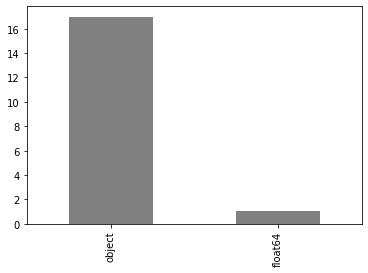

In [13]:
HC.dtype_check(data=df)

<AxesSubplot: >

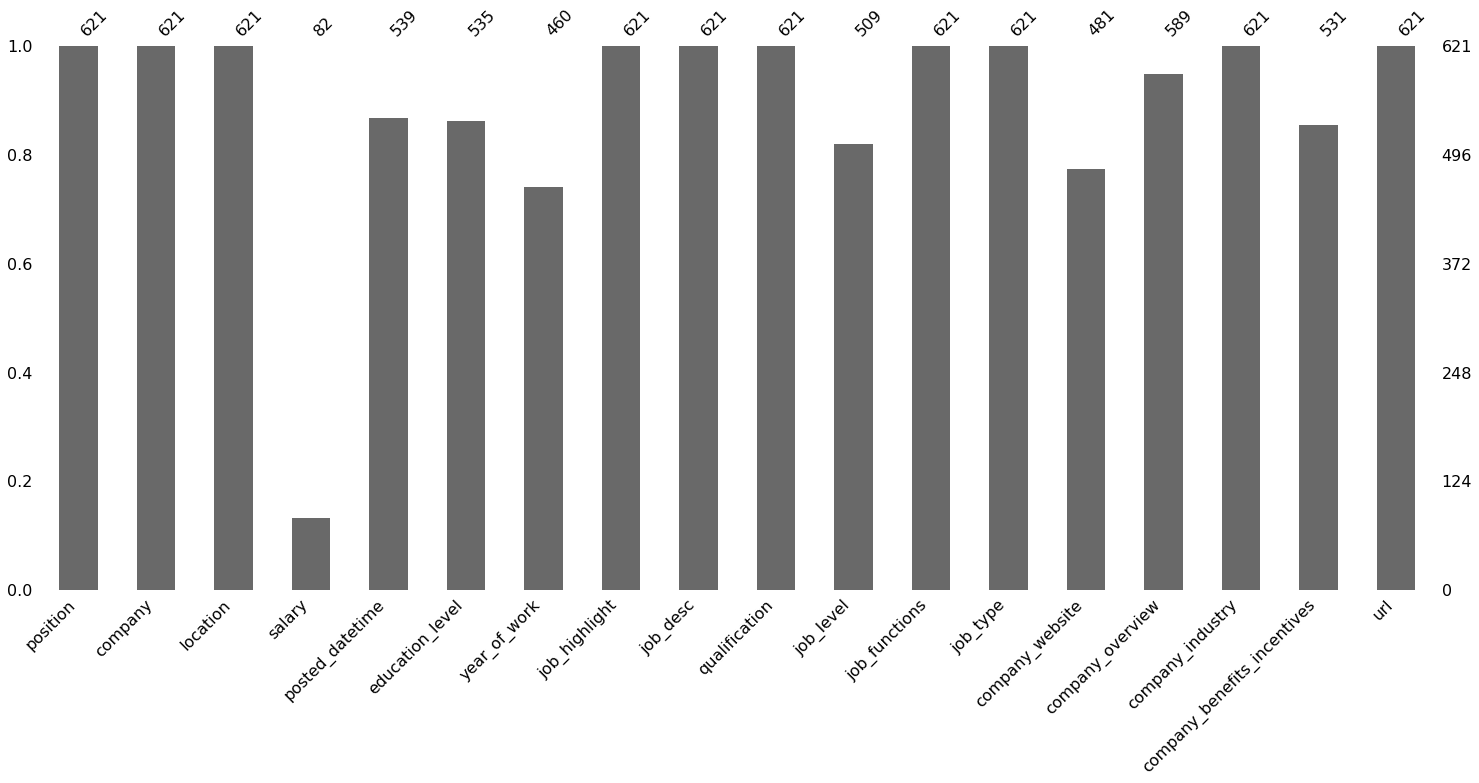

In [16]:
HC.msno_bar(data=df)

# 7. Export

In [15]:
df.to_csv('jobsdb_data.csv', index=False)